# Experiment for intrusion detection using CICIDS 2018 

1. It's a small experiment with only four of the .csv files in CICIDS 2018 dataset
2. Data is largely inconsistent. So it needs heavy cleaning.
3. Some csv files in Dataset is too large. Has to be loaded in chunk. They are ignored for now
4. Accuracy of above 95% is achieved.
5. Its only a experiment. Nothing too serious. I guess accuracy of above 95% can be achieved easily even considering entire dataset. Atleast most papers have

In [1]:
import pandas as pd
import numpy as np
import datatable as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
root='../input/cicids2018/CICIDS2018/'
paths=[root+filename for filename in os.listdir('../input/cicids2018/CICIDS2018')]
paths

['../input/cicids2018/CICIDS2018/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv',
 '../input/cicids2018/CICIDS2018/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv']

In [3]:

df=pd.read_csv(paths[0])
for path in paths[1:4]:
    df=pd.concat([df,pd.read_csv(path)])



    

**Example of Nonsensical data in datasets**

In [4]:
df.loc[df['Label'] == 'Label']

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
999999,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


**Another example of presence of inf and NaN in data**

In [5]:
print('presence of Nan and Inf:')
print(df[df.isna().any(axis=1)].filter(like='ts/s'))

presence of Nan:
        Flow Byts/s Flow Pkts/s Fwd Pkts/s Bwd Pkts/s
54581           NaN         inf          0          0
54738           NaN         inf          0          0
55515           NaN         inf          0          0
55620           NaN         inf          0          0
55760           NaN         inf          0          0
...             ...         ...        ...        ...
1048405         NaN         inf          0          0
1048421         NaN         inf          0          0
1048422         NaN         inf          0          0
1048424         NaN         inf          0          0
1048505         NaN         inf          0          0

[9756 rows x 4 columns]


In [6]:
df.Label.unique()

array(['Benign', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'Label',
       'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'FTP-BruteForce',
       'SSH-Bruteforce', 'Bot'], dtype=object)

In [7]:

df=df.drop(df.loc[df['Label']=='Label'].index,axis=0)
df=df.drop(['Timestamp','Flow Byts/s','Flow Pkts/s'],axis=1)
categories=df.Label.unique()
print(categories)

['Benign' 'DoS attacks-SlowHTTPTest' 'DoS attacks-Hulk'
 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris' 'FTP-BruteForce'
 'SSH-Bruteforce' 'Bot']


In [8]:



label=df.Label
features=df.drop('Label',axis=1)
del df
features=np.array(features)

features=MinMaxScaler().fit_transform(features)

label=np.array(label)
label = LabelEncoder().fit_transform(label).reshape(-1,1)
label = OneHotEncoder(sparse=False).fit_transform(label)
features=features.astype('float32')

x_train,x_test,y_train,y_test=train_test_split(features,label,test_size=0.05,shuffle=True)
print('x_train_shape:',x_train.shape)
print('y_train_shape:',y_train.shape)
print('x_test_shape:',x_test.shape)
print('y_test_shape:',y_test.shape)

del label
del features

x_train_shape: (3984581, 76)
y_train_shape: (3984581, 8)
x_test_shape: (209715, 76)
y_test_shape: (209715, 8)


In [9]:

import keras
from keras.layers import Dense,Input,Softmax,Dropout,BatchNormalization

from keras.models import Model


In [10]:

inp=Input(shape=(x_train.shape[1],))
x=Dense(units = 60, kernel_initializer = 'uniform', activation = 'relu')(inp)
x=Dropout(0.2)(x)
x=Dense(units = 50, kernel_initializer='uniform',activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(units = 40, kernel_initializer='uniform',activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(units=30,kernel_initializer='uniform',activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(units=20,kernel_initializer='uniform',activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu')(x)
op=Dense(units = len(categories), kernel_initializer = 'uniform', activation = 'softmax')(x)

classifier = Model(inp, op)

In [11]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=classifier.fit(x_train, y_train, batch_size = 1024, epochs = 20,validation_split=0.05)

Epoch 1/20
3697/3697 [==============================] - 14s 3ms/step - loss: 1.1424 - accuracy: 0.6883 - val_loss: 0.4909 - val_accuracy: 0.7944
Epoch 2/20
3697/3697 [==============================] - 12s 3ms/step - loss: 0.4472 - accuracy: 0.8032 - val_loss: 0.3046 - val_accuracy: 0.9086
Epoch 3/20
3697/3697 [==============================] - 12s 3ms/step - loss: 0.2860 - accuracy: 0.9072 - val_loss: 0.2263 - val_accuracy: 0.9086
Epoch 4/20
3697/3697 [==============================] - 12s 3ms/step - loss: 0.2199 - accuracy: 0.9079 - val_loss: 0.1967 - val_accuracy: 0.9083
Epoch 5/20
3697/3697 [==============================] - 12s 3ms/step - loss: 0.1900 - accuracy: 0.9260 - val_loss: 0.1464 - val_accuracy: 0.9533
Epoch 6/20
3697/3697 [==============================] - 12s 3ms/step - loss: 0.1390 - accuracy: 0.9517 - val_loss: 0.1151 - val_accuracy: 0.9536
Epoch 7/20
3697/3697 [==============================] - 12s 3ms/step - loss: 0.1119 - accuracy: 0.9557 - val_loss: 0.1030 - val_ac

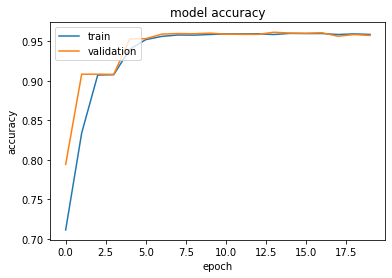

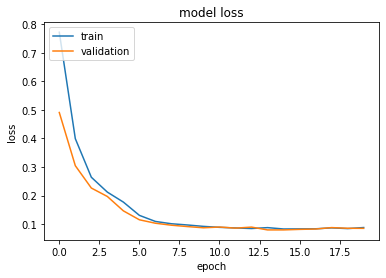

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Checking accuracy of classifier model with test_split as input**

In [13]:
prediction=classifier.predict(x_test)
accuracy=np.sum(np.argmax(prediction,axis=1)==np.argmax(y_test,axis=1))/len(y_test)
print('accuracy considering first three files:',accuracy)

accuracy considering first three files: 0.957299191760246
